# Классификация изображений

### Основная идея этого решения: взять предобученую на ImageNet сеть и дообучить под нашу задачу. 

## Дополнительная идея при подготовке данных:
### Используем YOLO3 detector для выделения автомобиля в кадре и удаления посторонних объектов для большей концентрации внимания сети на объекте классификации (фактически проведем AI "crop" на каждой картинке)

### Так как не удалось запустить библиотеку imageai c TF = 2, пришлось вынести код в сторонний ноутбук (на основе публичного ноутбука "Trying out ImageAi"). Листинг кода приведен ниже. 
### В процессе кроппинга картинок (и в некоторых случаях дополнительного разделения пополам - split)  из train был получен датасет cropped_split_train. Генератор данных для обучения и теста  будет брать уже предобработанные вышеуказанным способом данные. Таким образом, модель будет обучаться на максимально важной информации. 

## Код для препроцессинга данных.

In [8]:
'''
!pip3 install https://github.com/OlafenwaMoses/ImageAI/releases/download/2.0.2/imageai-2.0.2-py3-none-any.whl

import os
import zipfile
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from tqdm import tqdm_notebook
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img, save_img

%matplotlib inline

# DATA_PATH_ = '../input/carclassification/test' # '../input/test-train/'
# PATH_ = "../working/car/cropped_test" # рабочая директория

DATA_PATH_ = '../input/carclassification/train/train/' # '../input/test-train/'
PATH_ = "../working/car/cropped_train/" # рабочая директория
os.makedirs(PATH_,exist_ok=True)

#!wget https://github.com/OlafenwaMoses/ImageAI/releases/download/1.0/yolo.h5
from imageai.Detection import ObjectDetection
import os
import sys
sys.path.append("..")



execution_path = os.getcwd()

from imageai.Detection import ObjectDetection

detector = ObjectDetection()
detector.setModelTypeAsYOLOv3()
detector.setModelPath("../input/yoloh5/yolo.h5")
detector.loadModel()
custom_objects = detector.CustomObjects(car=True, truck=True) # ищем только объекты похожие на машины



def get_box(detections, size): 
    detect_largest_box = True 
    smallest_detected_area = 0.05 # допустимая доля площади картинки занимаемая объектом

    area = 0
    points = None

    if detect_largest_box == True:
        for detection in detections[1]:
            current_area = (detection['box_points'][2] - detection['box_points'][0]) * (detection['box_points'][3] - detection['box_points'][1])
            if current_area > area:
                area = current_area
                points = detection['box_points']
    else:
        points = detections[0]['box_points']

    img_area = size[0] * size[1] if smallest_detected_area != None else None
    r_ = area / img_area 
    
    if (img_area != None) and (r_< smallest_detected_area) :
        return None
    else:
        return points

def crop_image(source_image, input_type):
    image = None
    input_image = None

    image = load_img(source_image)
    input_image = img_to_array(image).astype(np.int32)
    detections = detector.detectCustomObjectsFromImage(
        custom_objects=custom_objects,
        input_type='array',
        input_image=input_image, 
        minimum_percentage_probability=20,
        extract_detected_objects=False,output_type='array'
    )
    box = get_box(detections, image.size)
    
    if box!=None:
        # Определяем размеры кропа
        w = box[2]-box[0]
        h = box[3]-box[1]
        h_= np.floor(max(w/1.77,h))
        
        dw = np.floor(0.08*w)
        dh = np.floor(max(0.1*h,(h_- h)*0.5))
        
        bl = max(0,box[0]-dw)
        br = min(box[2]+dw,image.size[0])
        bt = max(0,box[1]-dh)
        bb = min(box[3]+dh,image.size[1])

        box_=[bl,bt,br,bb]

        size_=image.size
        r_= (br-bl)*(bb-bt)/(size_[0] * size_[1])

        if r_<0.7:  # будем делать кроп только когда площадь авто меньше 70% площади картинки
            cropped_img = image.crop(box_)
            cropped = 1
        else:
            cropped_img = image
            cropped = 0
    else:
        cropped_img = image
        cropped = 0
    return cropped_img,cropped

def crop_dir(source_path, target_path, directory):
   
    if os.path.exists(target_path + directory) == False:
        os.mkdir(target_path + directory)

    filenames = os.listdir(source_path + directory)
    total_cropped = 0
    total = 0
    splitt = 0
    for filename in tqdm_notebook(filenames):
        image_path = os.path.join(execution_path , source_path + directory + '/' + filename)
        cropped_img,cropped = crop_image(image_path, 'array')
        total += 1 
        save_img(target_path + directory + '/'+ filename , cropped_img)
        if cropped == 1:
            total_cropped += 1 
            if cropped_img.size[0]/cropped_img.size[1]>1.5: 
                fn = filename.split('.')
                cropped_img1=cropped_img.crop([0,0,cropped_img.size[0]//2,cropped_img.size[1]])
                cropped_img2=cropped_img.crop([cropped_img.size[0]//2,0,cropped_img.size[0],cropped_img.size[1]])
                save_img(target_path + directory + '/' + fn[0]+'_1.'+fn[1], cropped_img1)
                save_img(target_path + directory + '/' + fn[0]+'_2.'+fn[1], cropped_img2)
                splitt += 1            
    print('proccessed:',total,'cropped:',total_cropped, 'split:',splitt) 

def crop_path(source_path, target_path, dirs):#, **kwargs):
    target_dirs = os.listdir(target_path)
    if os.path.exists(target_path) == False:
        os.mkdir(target_path)
    for i, directory in enumerate(dirs):
        print('Directory', str(i), 'of', str(len(dirs)), '...')
        crop_dir(source_path, target_path, directory)
        print('Images in directory', str(i), '"' + directory + '"', 'cropped')
        
# Обрабатываем 'train'
dirs=['0','1','2','3','4','5','6','7','8','9']
crop_path('../input/carclassification/train/train/', '../working/car/cropped_train/', dirs)
# Обрабатываем 'test'
dirs=['test_upload']
crop_path('../input/carclassification/test/', '../working/car/cropped_test/', dirs)

# Упаковываем 
import zipfile
import os

z = zipfile.ZipFile('../../kaggle/working/output.zip', 'w')        # Создание нового архива
for root, dirs, files in os.walk('../../kaggle/working/car/cropped_train/'): # Список всех файлов и папок в директории folder
    for file in files:
        z.write(os.path.join(root,file))         # Создание относительных путей и запись файлов в архив

z.close()

# Получаем ссылку на скачивание
import os
os.chdir(r'/kaggle/working')
from IPython.display import FileLink
FileLink(r'output.zip')
'''
# Скачиваем фйла и добавляем его в датасет на Kaggle, который потом используем в Input 

'\n!pip3 install https://github.com/OlafenwaMoses/ImageAI/releases/download/2.0.2/imageai-2.0.2-py3-none-any.whl\n\nimport os\nimport zipfile\nimport pandas as pd\nimport numpy as np\n\nfrom matplotlib import pyplot as plt\n\nfrom tqdm import tqdm_notebook\nfrom keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img, save_img\n\n%matplotlib inline\n\n# DATA_PATH_ = \'../input/carclassification/test\' # \'../input/test-train/\'\n# PATH_ = "../working/car/cropped_test" # рабочая директория\n\nDATA_PATH_ = \'../input/carclassification/train/train/\' # \'../input/test-train/\'\nPATH_ = "../working/car/cropped_train/" # рабочая директория\nos.makedirs(PATH_,exist_ok=True)\n\n#!wget https://github.com/OlafenwaMoses/ImageAI/releases/download/1.0/yolo.h5\nfrom imageai.Detection import ObjectDetection\nimport os\nimport sys\nsys.path.append("..")\n\n\n\nexecution_path = os.getcwd()\n\nfrom imageai.Detection import ObjectDetection\n\ndetector = ObjectDetection(

## С помощью данного кода предобработки получены следующие датасеты:
### 'cropped-split-train' - содержит как новые "дочерние" AI cropped & split файлы, так и старые "материнские" файлы из имеющегося датасета 'train'. Используется непосредственно для обучения. Имена AI cropped файлов образованы путем добавления окончаний '_0'. Имена split файлов образованы путем добавления окончаний '_1' и '_2' к имени разделяемого файла.
### 'cropped-car-test' - содержит AI cropped файлы из имеющегося датасета 'test' используется непосредственно для submission. Таким образом, обработав 'test', получаем улучшенный, в плане информации, датасет для submission.


In [9]:
!nvidia-smi

Mon May 24 16:17:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [10]:
#!pip install gdown # загрузка сохраненных моделей для восстановления сессии 
# (commit ни раз не удалось выполнить без сбоев)
#!gdown https://drive.google.com/uc?id=122_cMcmSiPegCe8RktT_aMrg5QcCxSbr
#!gdown https://drive.google.com/uc?id=1AzskfDI8yl9cby_9tPmBqKIB_YApKiCl
#!gdown https://drive.google.com/uc?id=16txY2mszCvTl9mrhU7z0bis_vcRGpQpN
#!gdown https://drive.google.com/uc?id=1iqqaVSU6WTEskg-tK6L-saNGlVox5L9f

#!gdown https://drive.google.com/uc?id=1WtxauZP9W-o4LBBtbxLiSWsbAiAUz7_D
#!gdown https://drive.google.com/uc?id=1afo0obxWKVdh2TOPjwTr1q-xII-f6Vcv
#!gdown https://drive.google.com/uc?id=1N1pClbpOYK6KTUfMGjZoe_cWbYAYx2LR

In [11]:
!pip install -q efficientnet

In [12]:
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor

  Cloning https://github.com/mjkvaak/ImageDataAugmentor to /tmp/pip-req-build-z006b98g
  Running command git clone -q https://github.com/mjkvaak/ImageDataAugmentor /tmp/pip-req-build-z006b98g
  Created wheel for ImageDataAugmentor: filename=ImageDataAugmentor-0.0.0-py3-none-any.whl size=29531 sha256=8de545de8e7dffa67f7844e37bc62091038b40fbe3e6ad56b692b20a28bceba7
  Stored in directory: /tmp/pip-ephem-wheel-cache-olgb1ezi/wheels/c9/bd/73/9cfa59d2393dae55bbcc30f5aa901f55fe531c66efebbc8fc3
Successfully built ImageDataAugmentor


**Работаем с Tensorflow v2**

In [13]:
!pip freeze > requirements.txt

# Основные настройки

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import zipfile
import csv
import sys
import os
from IPython.display import FileLink

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from keras.models import Sequential

from tensorflow.keras.applications.xception import Xception
import efficientnet.tfkeras as efn
from tensorflow.keras.layers import *

import albumentations
from ImageDataAugmentor.image_data_augmentor import *
import math
from sklearn.model_selection import train_test_split, StratifiedKFold

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

print(os.listdir("../input"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

['cropped-car-test', 'carclassification', 'cropped-split-train']
Python       : 3.7.10 | packaged by conda-forge | (default, Feb 19 2021, 16:07:37) 
Numpy        : 1.19.5
Tensorflow   : 2.4.1
Keras        : 2.4.0


In [15]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [16]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.

EPOCHS               = 8  # эпох на обучение
BATCH_SIZE           = 128 # 
LR                   = 1e-3
VAL_SPLIT            = 0.10 # сколько данных выделяем на тест = 10%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 320 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '../input/carclassification/'
PATH = "../working/car/" # рабочая директория
DATA_PATH_train = '../input/carclassification/train/'
DATA_PATH_test = '../input/carclassification/test/'

# Paths to the preproccesed datasets
CROPPED_DATA_PATH_train = '../input/cropped-split-train/' 
CROPPED_DATA_PATH_test = '../input/cropped-car-test/'


In [17]:
# Устаналиваем конкретное значение random seed для воспроизводимости
os.makedirs(PATH,exist_ok=True)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

# EDA / Анализ данных

In [18]:
train_df = pd.read_csv(DATA_PATH+"train.csv")
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")
train_df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [19]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


In [20]:
train_df.Category.value_counts()
# распределение классов достаточно равномерное - это хорошо

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

In [21]:
'''
print('Распаковываем картинки')
# Will unzip the files so that you can see them..
for data_zip in ['test.zip']: # ['train.zip', 'test.zip']:
    with zipfile.ZipFile(DATA_PATH+data_zip,"r") as z:
        z.extractall(PATH)
        
print(os.listdir(PATH))
'''

'\nprint(\'Распаковываем картинки\')\n# Will unzip the files so that you can see them..\nfor data_zip in [\'test.zip\']: # [\'train.zip\', \'test.zip\']:\n    with zipfile.ZipFile(DATA_PATH+data_zip,"r") as z:\n        z.extractall(PATH)\n        \nprint(os.listdir(PATH))\n'

Пример картинок (random sample)


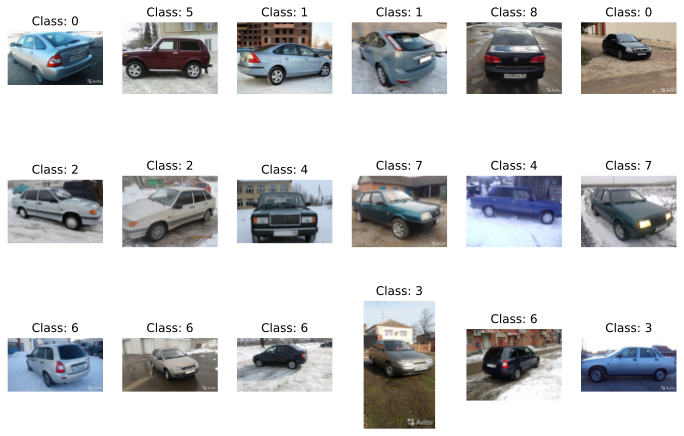

In [22]:
print('Пример картинок (random sample)')
plt.figure(figsize=(12,8))

random_image = train_df.sample(n=18)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_PATH_train+f'train/{random_image_cat[index]}/{path}')
    plt.subplot(3,6, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

Посмотрим на примеры картинок и их размеры чтоб понимать как их лучше обработать и сжимать.

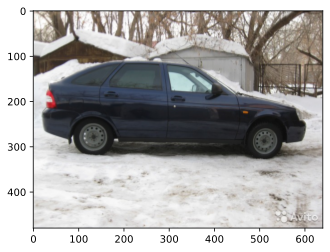

(640, 480)

In [23]:
image = PIL.Image.open(DATA_PATH_train+'/train/0/100380.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

Пример предобработанных картинок (random sample)


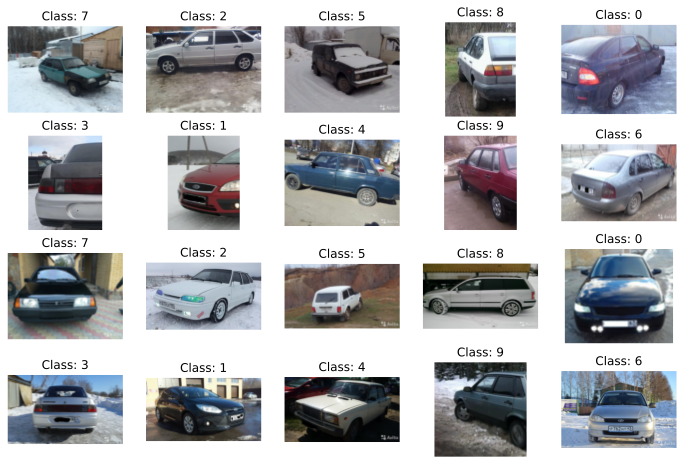

In [24]:
print('Пример предобработанных картинок (random sample)')
plt.figure(figsize=(12,8))

import os, random
random_image_paths=[]
random_image_cat=[]
for i in range(2):
    for d in os.listdir(CROPPED_DATA_PATH_train):
        random_image_paths.append(random.choice([x for x in os.listdir(CROPPED_DATA_PATH_train+d+'/') if os.path.isfile(os.path.join(CROPPED_DATA_PATH_train+d+'/', x))]))
        random_image_cat.append(d)

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(CROPPED_DATA_PATH_train+f'{random_image_cat[index]}/{path}')
    plt.subplot(4,5, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

# Подготовка данных

### Аугментация данных

In [25]:
# Аугментация данных важна, когда мы работаем с небольшим датасетом. Это как раз наш случай.

AUGMENTATIONS = albumentations.Compose([
    albumentations.Resize(IMG_SIZE, IMG_SIZE),
    #albumentations.RandomCrop(IMG_SIZE-64,IMG_SIZE-64)
    albumentations.HorizontalFlip(p=0.5),
    albumentations.ShiftScaleRotate(shift_limit=0.0625, 
                       scale_limit=0.01, 
                       interpolation=1, 
                       border_mode=4, 
                       rotate_limit=15, # 10
                       p=.75),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(brightness_limit=0.4, contrast_limit=0.4),
        albumentations.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1)
    ],p=0.5),
    albumentations.GaussianBlur(p=0.05),
    albumentations.HueSaturationValue(p=0.5),
    albumentations.RGBShift(p=0.5),
    albumentations.FancyPCA(alpha=0.1, always_apply=False, p=0.5)
    
])

train_datagen = ImageDataAugmentor(
        rescale=1./255,
        augment = AUGMENTATIONS,
        validation_split=VAL_SPLIT,seed=RANDOM_SEED
        )
        
test_datagen = ImageDataAugmentor(rescale=1./255,seed=RANDOM_SEED)


### Генерация данных

In [26]:
# Завернем наши данные в генераторы:

train_generator = train_datagen.flow_from_directory(
    DATA_PATH_train+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, 
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    DATA_PATH_train+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, 
    subset='validation') # set as validation data

cropped_train_generator = train_datagen.flow_from_directory(
    CROPPED_DATA_PATH_train,      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, 
    subset='training') # set as training data

cropped_test_generator = train_datagen.flow_from_directory(
    CROPPED_DATA_PATH_train,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, 
    subset='validation') # set as validation data

# Символ '_' в имени файла значит, что это предобработанный файл.
# Для локальной проверки  они лишние (их не будет в тестовых данных для submission), 
# поэтому создаем генератор на именах файлов из валидационной выборке, но только без предобработанных файлов.
no_split_files=[CROPPED_DATA_PATH_train+x for x in cropped_test_generator.filenames if not '_' in x] 
cats=[]
for f in no_split_files:
    cats.append(f.split('/')[-2])
cropped_val_df = pd.DataFrame({'Id':no_split_files, 'Category':cats}, 
                          columns=['Id', 'Category'])

cropped_val_generator = test_datagen.flow_from_dataframe( 
    dataframe=cropped_val_df,
    directory=None,
    x_col="Id",
    y_col="Category",
    shuffle=False,
    class_mode='categorical',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE) # set as test data (for demo purpose, as if for submission)

Found 14009 images belonging to 10 classes.
Found 1552 images belonging to 10 classes.
Found 26005 images belonging to 10 classes.
Found 2886 images belonging to 10 classes.
Found 1578 validated image filenames belonging to 10 classes.


Пример предобработанных кропом и аугментированных картинок из train_generator


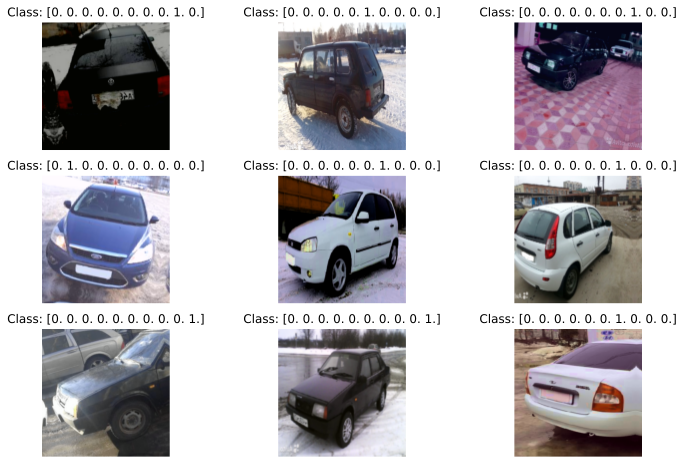

In [27]:

from skimage import io

def imshow(image_RGB):
    io.imshow(image_RGB)
    io.show()

x,y = cropped_train_generator.next()
print('Пример предобработанных кропом и аугментированных картинок из train_generator')
plt.figure(figsize=(12,8))

for i in range(0,9):
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
    plt.title('Class: '+str(y[i]))
    plt.axis('off')
plt.show()

# Построение модели

### Загружаем предобученную сеть :

In [28]:
base_model = efn.EfficientNetB7(weights='imagenet', include_top=False, input_shape = input_shape)

258441216/258434480 [==============================] - 3s 0us/step


### Проведем Transfer Learning - Step 0

In [29]:
# Для начала заморозим веса предобученной сети и обучим только "голову". 
# Делаем это для того, чтобы хорошо обученные признаки на Imagenet не затирались в самом начале нашего обучения
base_model.trainable = False

In [30]:
# base_model.summary()
print('Всего слоев в Base_Model:',len(base_model.layers))

Всего слоев в Base_Model: 806


In [31]:
inputs = Input(shape=input_shape)
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. 
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
x = BatchNormalization()(x)
# let's add a fully-connected layers
x = Dense(256, activation='elu')(x)
x = Dropout(0.25)(x)
x = BatchNormalization()(x)
x = Dense(256, activation='elu')(x)
x = Dropout(0.25)(x)
# and a logistic layer -- let's say we have 10 classes
predictions = Dense(CLASS_NUM, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=inputs, outputs=predictions)
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 320, 320, 3)]     0         
_________________________________________________________________
efficientnet-b7 (Functional) (None, 10, 10, 2560)      64097680  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2560)              10240     
_________________________________________________________________
dense (Dense)                (None, 256)               655616    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024  

## Обучение модели

Добавим ModelCheckpoint чтоб сохранять прогресс обучения модели и можно было потом подгрузить и дообучить модель.

In [32]:
# Вспомогательные функции для работы с history
def save_history(history,name):
    np.save(name,history.history)
def load_history(name):
    return np.load(name,allow_pickle='TRUE').item()  

def plot_history(history):
    if type(history)==dict:
        
        acc = history['accuracy']
        val_acc = history['val_accuracy']
        loss = history['loss']
        val_loss = history['val_loss']
    else:

        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()    

def Get_Downloadable_Link(fn):
    # создадим ссылку на загрузку файла fn из output
    os.chdir(r'/kaggle/working')
    return FileLink(fn)

def step_decay(epoch):
    # используем пошаговое уменьшение learning rate
    initial_lrate = LR
    drop = 0.7
    epochs_drop = 3
    lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
    return lrate


checkpoint = ModelCheckpoint('best_model_step0.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')

earlystop = EarlyStopping(monitor = 'val_accuracy',
                         patience = 4,
                          restore_best_weights = True)
lr_scheduler = LearningRateScheduler(step_decay)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.25,
                              patience=2,
                              min_lr=0.0000001,
                              verbose=1,
                              mode='auto')
callbacks_list = [checkpoint, earlystop, lr_scheduler,reduce_lr]


Обучаем:

In [35]:
history = model.fit(
        cropped_train_generator,
        steps_per_epoch = len(cropped_train_generator),
        validation_data = cropped_test_generator, 
        validation_steps = len(cropped_test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

# Рекомендация: попробуйте применить transfer learning с fine-tuning

##### Так как выполнение ноутбука приходилось прерыввать, то результат исполнения не удалось сохранить. Вместо этого сохранялась история, которую можно воспроизвести из файлов с помощью вспомогательной функции load_history(). 

In [ ]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
model.save('../working/model_step0.hdf5')
model.load_weights('best_model_step0.hdf5')
save_history(history,'step0.npy')
Get_Downloadable_Link('best_model_step0.hdf5') # для сохранения данных на локальный диск

In [ ]:
Get_Downloadable_Link('step0.npy') # для сохранения данных на локальный диск

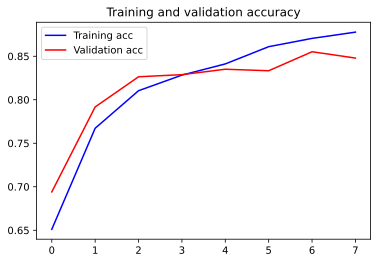

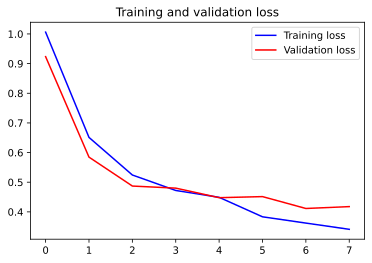

In [38]:
# восстановим модель и историю после перезагрузки ноутбука
# model.load_weights('best_model_step0.hdf5')
# history = load_history('step0.npy') 
plot_history(history)

In [39]:
scores = model.evaluate(cropped_val_generator, steps=len(cropped_val_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

13/13 [==============================] - 22s 2s/step - loss: 0.4412 - accuracy: 0.8416
Accuracy: 84.16%


In [40]:
import gc
gc.collect()

14709

# Переходим к Fine-Tuning: Step1 - размораживаем половину весов бейзмодели

In [41]:
base_model.trainable = True
fine_tune_at = len(base_model.layers) // 2

# Заморозим половину слоев перед тонкой надстройкой
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
model.summary()    

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 320, 320, 3)]     0         
_________________________________________________________________
efficientnet-b7 (Functional) (None, 10, 10, 2560)      64097680  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2560)              10240     
_________________________________________________________________
dense (Dense)                (None, 256)               655616    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024  

In [42]:
# Так как при разморозке приходится потреблять больше памяти, то придется уменьшать BATCH_SIZE и перегенировать данные
EPOCHS               = 8  # эпох на обучение
BATCH_SIZE           = 32 # 32 64 уменьшаем batch если сеть большая, иначе не влезет в память на GPU
LR                   =  1e-4
IMG_SIZE             = 320 # какого размера подаем изображения в сеть
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)



cropped_train_generator = train_datagen.flow_from_directory(
    CROPPED_DATA_PATH_train,      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, 
    subset='training') # set as training data

cropped_test_generator = train_datagen.flow_from_directory(
    CROPPED_DATA_PATH_train,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, 
    subset='validation') # set as validation data

# Символ '_' в имени файла значит, что это предобработанный файл.
# Для локальной проверки  они лишние (их не будет в тестовых данных для submission), 
# поэтому создаем генератор на именах файлов из валидационной выборке, но только без предобработанных файлов.
no_split_files=[CROPPED_DATA_PATH_train+x for x in cropped_test_generator.filenames if not '_' in x] 
cats=[]
for f in no_split_files:
    cats.append(f.split('/')[-2])
cropped_val_df = pd.DataFrame({'Id':no_split_files, 'Category':cats}, 
                          columns=['Id', 'Category'])

cropped_val_generator = test_datagen.flow_from_dataframe( 
    dataframe=cropped_val_df,
    directory=None,
    x_col="Id",
    y_col="Category",
    shuffle=False,
    class_mode='categorical',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE) # set as test data (for demo purpose, as if for submission)

Found 26005 images belonging to 10 classes.
Found 2886 images belonging to 10 classes.
Found 1578 validated image filenames belonging to 10 classes.


In [44]:
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [ ]:
def step_decay(epoch):
    # используем пошаговое уменьшение lear
    initial_lrate = LR
    drop = 0.85
    epochs_drop = 1
    lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
    return lrate

checkpoint = ModelCheckpoint('best_model_step1.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
callbacks_list = [checkpoint, earlystop, lr_scheduler,reduce_lr]
history = model.fit(
        cropped_train_generator,
        steps_per_epoch = len(cropped_train_generator),
        validation_data = cropped_test_generator, 
        validation_steps = len(cropped_test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)


##### Так как выполнение ноутбука приходилось прерыввать, то результат исполнения не удалось сохранить. Вместо этого сохранялась история, которую можно воспроизвести из файлов с помощью вспомогательной функции load_history(). 

In [ ]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)

model.save('../working/model_step1.hdf5')
model.load_weights('best_model_step1.hdf5')
save_history(history,'step1.npy')
#load_history
Get_Downloadable_Link('best_model_step1.hdf5')

In [ ]:
Get_Downloadable_Link('step1.npy')

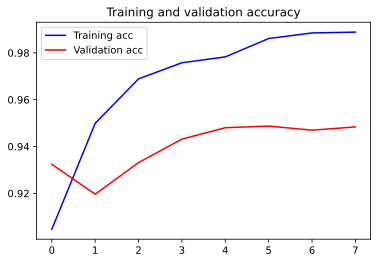

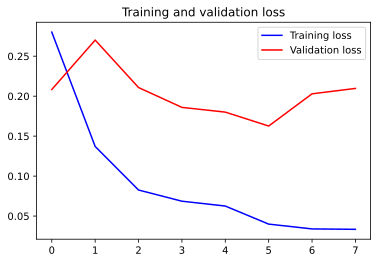

In [45]:
# восстановим модель и историю после перезагрузки ноутбука
# model.load_weights('best_model_step1.hdf5')
# history = load_history('step1.npy')
plot_history(history) 

In [46]:
scores = model.evaluate(cropped_val_generator, steps=len(cropped_val_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

50/50 [==============================] - 29s 432ms/step - loss: 0.2001 - accuracy: 0.9536
Accuracy: 94.55%


# Разморозим все слои для обучения - Step 2

In [47]:
for layer in base_model.layers:
    layer.trainable = True
for layer in model.layers:
    layer.trainable = True
    
for layer in model.layers:
    print(layer, layer.trainable)   

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f2015188790> True
<tensorflow.python.keras.engine.functional.Functional object at 0x7f2014d7cf50> True
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7f201517f090> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f20902ade50> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f2092162ad0> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f20921700d0> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f2092179210> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f20902bb050> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f2092162a90> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f209216b090> True


In [48]:
model.summary() 

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 320, 320, 3)]     0         
_________________________________________________________________
efficientnet-b7 (Functional) (None, 10, 10, 2560)      64097680  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2560)              10240     
_________________________________________________________________
dense (Dense)                (None, 256)               655616    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024  

In [60]:
# Так как при разморозке приходится потреблять больше памяти, то придется уменьшать BATCH_SIZE и перегенировать данные
EPOCHS               = 8  # эпох на обучение
BATCH_SIZE           = 10 # 32 64 уменьшаем batch если сеть большая, иначе не влезет в память на GPU
LR                   = 0.00001
IMG_SIZE             = 320 # какого размера подаем изображения в сеть
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

TEST_IMG_SIZE             = 512 # 320 # какого размера подаем изображения в сеть при тестировании
                           # оказалось, что увеличение этого параметра увеличивает score !!! 
TEST_BATCH_SIZE      = 96 # 128


cropped_train_generator = train_datagen.flow_from_directory(
    CROPPED_DATA_PATH_train,      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, 
    subset='training') # set as training data

cropped_test_generator = train_datagen.flow_from_directory(
    CROPPED_DATA_PATH_train,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, 
    subset='validation') # set as validation data

# Символ '_' в имени файла значит, что это предобработанный файл.
# Для локальной проверки  они лишние (их не будет в тестовых данных для submission), 
# поэтому создаем генератор на именах файлов из валидационной выборке, но только без предобработанных файлов.
no_split_files=[CROPPED_DATA_PATH_train+x for x in cropped_test_generator.filenames if (not '_' in x)]#(not '_1' in x) and (not '_2' in x)] 
cats=[]
for f in no_split_files:
    cats.append(f.split('/')[-2])
cropped_val_df = pd.DataFrame({'Id':no_split_files, 'Category':cats}, 
                          columns=['Id', 'Category'])

cropped_val_generator = test_datagen.flow_from_dataframe( 
    dataframe=cropped_val_df,
    directory=None,
    x_col="Id",
    y_col="Category",
    shuffle=False,
    class_mode='categorical',
    target_size=(TEST_IMG_SIZE, TEST_IMG_SIZE),
    batch_size=TEST_BATCH_SIZE) # set as test data (for demo purpose, as if for submission)

cropped_test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=CROPPED_DATA_PATH_test+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    target_size=(TEST_IMG_SIZE, TEST_IMG_SIZE),
    batch_size=TEST_BATCH_SIZE) # set as submission-test data

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory= DATA_PATH_test+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    target_size=(TEST_IMG_SIZE, TEST_IMG_SIZE),
    batch_size=TEST_BATCH_SIZE) # set as submission-test data

Found 26005 images belonging to 10 classes.
Found 2886 images belonging to 10 classes.
Found 1578 validated image filenames belonging to 10 classes.
Found 6675 validated image filenames.
Found 6675 validated image filenames.


In [50]:
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])


In [ ]:
def step_decay(epoch):
    # используем пошаговое уменьшение lear
    initial_lrate = LR
    drop = 0.7
    epochs_drop = 1
    lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
    return lrate

checkpoint = ModelCheckpoint('best_model_step2.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
callbacks_list = [checkpoint, earlystop, lr_scheduler,reduce_lr]
history = model.fit(
        cropped_train_generator,
        steps_per_epoch = len(cropped_train_generator),
        validation_data = cropped_test_generator, 
        validation_steps = len(cropped_test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

##### Так как выполнение ноутбука приходилось прерыввать, то результат исполнения не удалось сохранить. Вместо этого сохранялась история, которую можно воспроизвести из файлов с помощью вспомогательной функции load_history(). 

In [ ]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
model.save('../working/model_step2.hdf5')
model.load_weights('best_model_step2.hdf5')

save_history(history,'step2.npy')
#load_history
Get_Downloadable_Link('best_model_step2.hdf5')

In [ ]:
Get_Downloadable_Link('step2.npy')

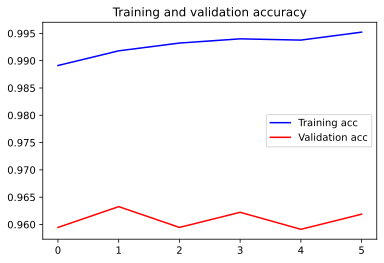

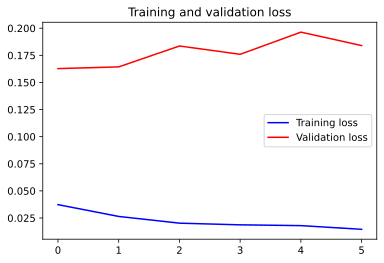

In [51]:
# восстановим модель и историю после перезагрузки ноутбука
#model.load_weights('best_model_step2.hdf5')
#history = load_history('step2.npy')
plot_history(history)

In [61]:
scores = model.evaluate(cropped_val_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

17/17 [==============================] - 51s 3s/step - loss: 0.1218 - accuracy: 0.9772
Accuracy: 97.72%


# Submit after Step2

In [53]:
print('количество примеров в тесте:',test_sub_generator.samples)

количество примеров в тесте: 6675


In [58]:
test_sub_generator.reset()
predictions = model.predict(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (cropped_train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

53/53 [==============================] - 95s 2s/step


In [59]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission_'+str(IMG_SIZE)+'_STEP2.csv', index=False)
print('Save submit')


Save submit


### Результаты:
#### Если брать TEST_IMG_SIZE = 320, то полученный файл 'submission_320_STEP2' получал 
score = 97.018.
#### Если брать TEST_IMG_SIZE = 512, то полученный файл 'submission_512_STEP2' получал 
score = 97.108.

# TTA submit after Step 2

In [63]:

BATCH_SIZE           = 96 #  
IMG_SIZE             = 512 # какого размера подаем изображения в сеть (320, 512)


AUGMENTATIONS = albumentations.Compose([
    albumentations.Resize(IMG_SIZE, IMG_SIZE),
    #albumentations.RandomCrop(IMG_SIZE-64,IMG_SIZE-64), # add random crop
    albumentations.HorizontalFlip(p=0.5),
    albumentations.ShiftScaleRotate(shift_limit=0.0625, 
                       scale_limit=0.01, 
                       interpolation=1, 
                       border_mode=4, 
                       rotate_limit=15, 
                       p=.75),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(brightness_limit=0.4, contrast_limit=0.4),
        albumentations.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1)
    ],p=0.5),
    
    #albumentations.RandomBrightnessContrast(brightness_limit=(-0.1,0.4), contrast_limit=(-0.1,0.4)),
    
    
    albumentations.GaussianBlur(p=0.05),
    albumentations.HueSaturationValue(p=0.5),
    albumentations.RGBShift(p=0.5),
    albumentations.FancyPCA(alpha=0.1, always_apply=False, p=0.5)
    
])

train_datagen = ImageDataAugmentor(
        rescale=1./255,
        augment = AUGMENTATIONS,
        validation_split=VAL_SPLIT,seed=RANDOM_SEED
        )
        
test_datagen = ImageDataAugmentor(rescale=1./255,seed=RANDOM_SEED)

tta_test_datagen = ImageDataAugmentor(
        rescale=1./255,
        augment = AUGMENTATIONS,
        seed=RANDOM_SEED
        )


train_generator = train_datagen.flow_from_directory(
    DATA_PATH_train+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, 
    subset='training') # set as training data




no_split_files=[CROPPED_DATA_PATH_train+x for x in cropped_test_generator.filenames if not '_' in x] 
cats=[]
for f in no_split_files:
    cats.append(f.split('/')[-2])
cropped_val_df = pd.DataFrame({'Id':no_split_files, 'Category':cats}, 
                          columns=['Id', 'Category'])
cropped_val_tta_generator = tta_test_datagen.flow_from_dataframe( # данные для оценки ТТA на имеющихся размеченных данных 'cropped_train_val'
    dataframe=cropped_val_df,
    directory=None,
    x_col="Id",
    y_col="Category",
    shuffle=False,
    class_mode='categorical',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE  ) # set for test tta with cropped 'train' data, i.e. 'cropped_train_val' as if for cropped test data




test_sub_generator = tta_test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=DATA_PATH_test+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,) # set as tta submission on pure 'test' data

cropped_test_sub_generator = tta_test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory= CROPPED_DATA_PATH_test+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)  # set as tta submission-test data with specially preprocessed 'test' data




Found 14009 images belonging to 10 classes.
Found 1578 validated image filenames belonging to 10 classes.
Found 6675 validated image filenames.
Found 6675 validated image filenames.


## Now go to submit TTA on pure 'test' data

In [69]:
tta_steps = 10
predictions = []

for i in range(tta_steps):
    preds = model.predict(test_sub_generator,steps=len(test_sub_generator),  verbose=1) 
    predictions.append(preds)

pred = np.mean(predictions, axis=0)

70/70 [==============================] - 212s 3s/step


In [70]:
predictions = np.argmax(pred, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, 
                          columns=['Id', 'Category'])

submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission_TTA_'+str(IMG_SIZE)+'_after_Step2.csv', index=False)

### Результат: 0.97468 

## Now go to submit TTA on the cropped (preliminary proccessed) 'test' data: cropped-car-test dataset 

In [71]:
tta_steps = 10
predictions = []

for i in range(tta_steps):
    preds = model.predict(cropped_test_sub_generator,steps=len(cropped_test_sub_generator),  verbose=1) 
    predictions.append(preds)

pred = np.mean(predictions, axis=0)

70/70 [==============================] - 212s 3s/step


In [72]:
predictions = np.argmax(pred, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]
filenames_with_dir=cropped_test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, 
                          columns=['Id', 'Category'])

submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission_TTA_'+str(IMG_SIZE)+'_after_Step2_cropped.csv', index=False)

### Результат: 0.97228

In [67]:
tta_steps = 10
predictions = []

for i in range(tta_steps):
    pred1 = model.predict(test_sub_generator,steps=len(test_sub_generator),  verbose=1)  
    pred2 = model.predict(cropped_test_sub_generator,steps=len(cropped_test_sub_generator),  verbose=1) 
    preds=pred1+pred2
    predictions.append(preds)

pred = np.mean(predictions, axis=0)

70/70 [==============================] - 211s 3s/step


In [68]:
predictions = np.argmax(pred, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]
filenames_with_dir=cropped_test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, 
                          columns=['Id', 'Category'])

submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission_TTA_'+str(IMG_SIZE)+'_after_Step2_unicropped.csv', index=False)

### Результат: 0.97423

# Увеличиваем размер картинки Step 3

In [64]:
base_model = efn.EfficientNetB7(weights='imagenet', include_top=False, input_shape = input_shape)
base_model.trainable = True

In [66]:
AUGMENTATIONS = albumentations.Compose([
    #A.RandomBrightness(limit=0.2, p=0.5),
    albumentations.ShiftScaleRotate(shift_limit=0.0625, 
                       scale_limit=0.01, 
                       interpolation=1, 
                       border_mode=4, 
                       rotate_limit=10, 
                       p=.75),
    albumentations.HorizontalFlip(p=0.5),
    #A.HueSaturationValue(p=0.5)
])
train_datagen = ImageDataAugmentor(
        rescale=1./255,
        augment = AUGMENTATIONS,
        validation_split=VAL_SPLIT,seed=RANDOM_SEED
        )
        
test_datagen = ImageDataAugmentor(rescale=1./255,seed=RANDOM_SEED)

In [67]:
# Так как при разморозке приходится потреблять больше памяти, то придется уменьшать BATCH_SIZE и перегенировать данные
EPOCHS               = 5  # эпох на обучение
BATCH_SIZE           = 8 # 32 64 уменьшаем batch если сеть большая, иначе не влезет в память на GPU
LR                   = 1e-5
IMG_SIZE             = 512 # какого размера подаем изображения в сеть
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)
TEST_BATCH_SIZE      = 96
cropped_train_generator = train_datagen.flow_from_directory(
    CROPPED_DATA_PATH_train,      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, 
    subset='training') # set as training data

cropped_test_generator = train_datagen.flow_from_directory(
    CROPPED_DATA_PATH_train,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, 
    subset='validation') # set as validation data

# Символ '_' в имени файла значит, что это половинка картинки.
# Для локальной проверки  они лишние (их не будет в тестовых данных для submission), 
# поэтому создаем генератор на валидационной выборке, но только без таких половинок.
no_split_files=[CROPPED_DATA_PATH_train+x for x in cropped_test_generator.filenames if (not '_' in x)]#(not '_1' in x) and (not '_2' in x)] 
cats=[]
for f in no_split_files:
    cats.append(f.split('/')[-2])
cropped_val_df = pd.DataFrame({'Id':no_split_files, 'Category':cats}, 
                          columns=['Id', 'Category'])

cropped_val_generator = test_datagen.flow_from_dataframe( 
    dataframe=cropped_val_df,
    directory=None,
    x_col="Id",
    y_col="Category",
    shuffle=False,
    class_mode='categorical',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=TEST_BATCH_SIZE) # set as test data (for demo purpose, as if for submission)

cropped_test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=CROPPED_DATA_PATH_test+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=TEST_BATCH_SIZE) # set as submission-test data

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory= DATA_PATH_test+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=TEST_BATCH_SIZE) # set as submission-test data

Found 26005 images belonging to 10 classes.
Found 2886 images belonging to 10 classes.
Found 1578 validated image filenames belonging to 10 classes.
Found 6675 validated image filenames.
Found 6675 validated image filenames.


In [57]:
def step_decay(epoch):
    # используем пошаговое уменьшение lear
    initial_lrate = LR
    drop = 0.7
    epochs_drop = 1
    lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
    return lrate

checkpoint = ModelCheckpoint('best_model_step3.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')

lr_scheduler = LearningRateScheduler(step_decay)

callbacks_list = [checkpoint, earlystop, lr_scheduler,reduce_lr]
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])
history = model.fit(
        cropped_train_generator,
        steps_per_epoch = len(cropped_train_generator),
        validation_data = cropped_test_generator, 
        validation_steps = len(cropped_test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

Epoch 1/5
3251/3251 [==============================] - 2391s 725ms/step - loss: 0.0179 - accuracy: 0.9946 - val_loss: 0.1852 - val_accuracy: 0.9602

Epoch 00001: saving model to best_model_step3.hdf5
Epoch 2/5
3251/3251 [==============================] - 2365s 727ms/step - loss: 0.0171 - accuracy: 0.9948 - val_loss: 0.2156 - val_accuracy: 0.9584

Epoch 00002: saving model to best_model_step3.hdf5
Epoch 3/5
3251/3251 [==============================] - 2437s 750ms/step - loss: 0.0142 - accuracy: 0.9960 - val_loss: 0.1895 - val_accuracy: 0.9615

Epoch 00003: saving model to best_model_step3.hdf5

Epoch 00003: ReduceLROnPlateau reducing learning rate to 8.575000265409471e-07.
Epoch 4/5
3251/3251 [==============================] - 2359s 726ms/step - loss: 0.0152 - accuracy: 0.9952 - val_loss: 0.1980 - val_accuracy: 0.9650

Epoch 00004: saving model to best_model_step3.hdf5
Epoch 5/5
3251/3251 [==============================] - 2356s 725ms/step - loss: 0.0122 - accuracy: 0.9969 - val_loss: 0

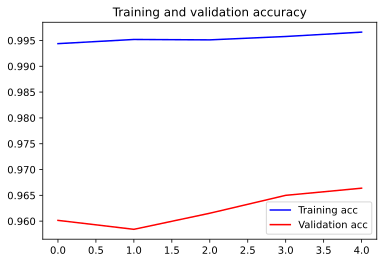

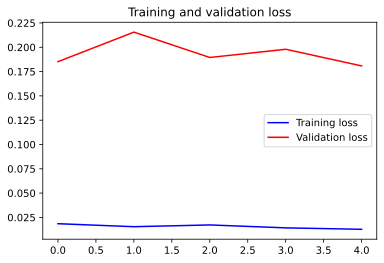

In [58]:
plot_history(history) 

In [60]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
model.save('../working/model_step3.hdf5')


In [45]:
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [68]:
model.load_weights('best_model_step3.hdf5')

In [62]:
save_history(history,'step3.npy')
#load_history
Get_Downloadable_Link('best_model_step3.hdf5')

/kaggle/working/best_model_step3.hdf5

In [64]:
scores = model.evaluate(cropped_val_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

17/17 [==============================] - 52s 3s/step - loss: 0.1130 - accuracy: 0.9772
Accuracy: 97.72%


# Предсказание на тестовых данных после Step 3

In [65]:
test_sub_generator.reset()
predictions = model.predict(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (cropped_train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

70/70 [==============================] - 225s 3s/step


In [66]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission.csv', index=False)
print('Save submit')

# Рекомендация: попробуйте добавить Test Time Augmentation (TTA)
# https://towardsdatascience.com/test-time-augmentation-tta-and-how-to-perform-it-with-keras-4ac19b67fb4d

Save submit


### Результат: 0.97363

# Результаты и выводы.

* Работа с ноутбуками на kaggle в режиме GPU требует особой внимательности. Многочисленные сбои могут приводить к потерям результатов и бесполезной траты квоты GPU. В этой связи, после каждой длительной операции полученные модели и истории сохранялись на локальный диск, а затем отправлялись в облако и в следующую сессию загружались по ссылкам с помощью gdown. Модели восстанавливались и работа продолжалась. Пришлось потратить почти три недельные квоты GPU. 
* Применение LR scheduling позволило улучшить модель практически на всех этапах 
* Увеличение размера картинки до 512 существенно утяжелило процесс обучения, но в итоге оказалось хуже чем обучение на предобработанном датасете с размером картинки 320 и последующим тестированием на 512.
* С помощью специальной предобработки обучающего датасета удалось сконцентрировать внимание сети на крупных отличительных фрагментах и тем самым увеличить score  при увеличении размера картинки на тесте до 512. При этом попытки провести submission на предобработанном таким же образом тестовом датасете существенных улучшений не принесли.
* Увеличение размера картинки на предобученной сети до 512 дало неплохое улучшение (97.363 vs 97.108 at 320), но техника ТТА оказалась эффективнее.
* Проводились различные эксперименты с архитектурой головы в плане размера и количества Dense слоев. Существенных преимуществ увеличением размера слоя достичь не удалось, к тому же это сильно "удорожало модель". Поэтому выбор пал на два FC  с размерами 256. 
* Применены функции callback Keras: earlystop, reduce_lr, lr_scheduler
* Применение Albumentations сильно улучшило результат.
* TTA (Test Time Augmentation) на размере 512 позволило поднять score на 0.33% 
* Техника ТТА проверялась и на предобработанной тестовой выборке (97.228) и на объединении результатов от чистой и предобработанной выборок (97.423). Тем не менее победа осталась за TTA над чистой выборкой.
## Score = 97.468